## Train model to detect ships in satellite images

In [1]:
import polars as pl
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
import sys

# autoreload changes from local files
%load_ext autoreload
%autoreload 2

# dataframe display settings
pl.Config.set_fmt_str_lengths(100)
pl.Config.set_tbl_rows(100)
pl.Config.set_tbl_cols(50)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


polars.config.Config

In [2]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

In [3]:
from airbus_ship_detection.augmentation import CenterCrop, DualCompose, HorizontalFlip, RandomCrop, VerticalFlip
from airbus_ship_detection import configs
from airbus_ship_detection.datasets import AirbusDataset
from airbus_ship_detection import inference
from airbus_ship_detection import losses
from airbus_ship_detection import metrics
from airbus_ship_detection import models
from airbus_ship_detection import processing
from airbus_ship_detection import trainer
from airbus_ship_detection import visuals

/Users/dknoors/Projects/airbus-ship-detection/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load and prepare data

In [4]:
# load with polars
df_segments = pl.read_csv(configs.DIR_DATA / "train_ship_segmentations_v2.csv")

# add number of ships
df_segments = processing.process_labels(df_segments, 
                                        ratio_img_wo_ships=configs.RATIO_IMG_WO_SHIPS,
                                        random_state=configs.RANDOM_STATE)
df_segments.head()

Before undersampling, dataset size: 231723
After undersampling, dataset size: 83223


ImageId,EncodedPixels,n_ships,has_ship
str,str,u32,bool
"""000155de5.jpg""","""264661 17 265429 33 266197 33 266965 33 267733 33 268501 33 269269 33 270037 33 270805 33 271573 33 …",1,true
"""000194a2d.jpg""","""360486 1 361252 4 362019 5 362785 8 363552 10 364321 10 365090 9 365858 10 366627 10 367396 9 368165…",5,true
"""000194a2d.jpg""","""51834 9 52602 9 53370 9 54138 9 54906 9 55674 7 56442 7 57210 7 57978 7 58746 7 59514 7 60282 7 6105…",5,true
"""000194a2d.jpg""","""198320 10 199088 10 199856 10 200624 10 201392 10 202160 10 202928 10 203696 10 204464 10 205232 10 …",5,true
"""000194a2d.jpg""","""55683 1 56451 1 57219 1 57987 1 58755 1 59523 1 60291 1""",5,true


In [5]:
df_train, df_val = processing.split_train_val(df_segments, random_state=configs.RANDOM_STATE, train_size=configs.TRAIN_SIZE, test_size=configs.TEST_SIZE, verbose=True)

Number of unique images in train: 2500, val: 250


In [6]:
df_train['has_ship'].value_counts()

has_ship,count
bool,u32
true,4638
false,85


In [7]:
df_train['n_ships'].value_counts().sort('n_ships')

n_ships,count
u32,u32
0,85
1,1538
2,870
3,504
4,368
5,265
6,222
7,161
8,144


# Train model

In [15]:
def main(model_name='UNET', run_id=0):
    print(f"Model: {model_name}, Run ID: {run_id}")

    # data augmentation
    train_transform = DualCompose([HorizontalFlip(), VerticalFlip(), RandomCrop((256,256,3))])
    val_transform = DualCompose([CenterCrop((512,512,3))])

    # Initialize dataset
    train_dataset = AirbusDataset(df_train, transform=train_transform, mode='train')
    val_dataset = AirbusDataset(df_val, transform=val_transform, mode='validation')

    print('Train samples : %d | Validation samples : %d' % (len(train_dataset), len(val_dataset)))

    # Get loaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=configs.BATCH_SZ_TRAIN, shuffle=True, num_workers=0)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=configs.BATCH_SZ_VALID, shuffle=True, num_workers=0)

    if configs.SHOW_IMG_LOADER == True:
        # Display some images from loader
        images, mask = next(iter(train_loader))
        processing.imshow_mask(torchvision.utils.make_grid(images, nrow=1), torchvision.utils.make_grid(mask, nrow=1))
        plt.show()
        
    # Train
    if not model_name:
        model_name = configs.MODEL
    if not run_id:
        run_id = configs.RUN_ID

    model = models.MODELS[model_name]
    print(f"Model: {model_name}")
        
    if configs.LOSS == 'BCEWithDigits':
        criterion = nn.BCEWithLogitsLoss()
    elif configs.LOSS == 'FocalLossWithDigits':
        criterion = losses.MixedLoss(10, 2)
    elif configs.LOSS == 'BCEDiceWithLogitsLoss':
        criterion = losses.BCEDiceWithLogitsLoss()
    elif configs.LOSS == 'BCEJaccardWithLogitsLoss':
        criterion = losses.BCEJaccardWithLogitsLoss()
    else:
        raise NameError("loss not supported")

    trainer.train(init_optimizer=lambda lr: optim.Adam(model.parameters(), lr=lr),
            lr = configs.LR,
            n_epochs = configs.N_EPOCHS,
            model = model,
            model_name = model_name,
            criterion=criterion,
            train_loader=train_loader,
            valid_loader=val_loader,
            train_batch_sz= configs.BATCH_SZ_TRAIN,
            valid_batch_sz= configs.BATCH_SZ_VALID,
            fold=run_id
            )


    # Plot losses
    log_path = configs.DIR_LOGS / f"{model_name}_{run_id}.log"
    logs = pd.read_json(log_path, lines=True)

    plt.figure(figsize=(26,6))
    plt.subplot(1, 2, 1)
    plt.plot(logs.step[logs.loss.notnull()],
                logs.loss[logs.loss.notnull()],
                label="on training set")

    plt.plot(logs.step[logs.valid_loss.notnull()],
                logs.valid_loss[logs.valid_loss.notnull()],
                label = "on validation set")
            
    plt.xlabel('step')
    plt.legend(loc='center left')
    plt.tight_layout()
    plt.show()


    # Model inference
    model = inference.load_model(model_name=model_name, run_id=run_id)
    model.eval()

    val_dataset = AirbusDataset(df_val, transform=val_transform)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=True, num_workers=0)

    # Display some images from loader
    images, gt = next(iter(val_loader))
    gt = gt.data.cpu()
    images = images.to(trainer.get_torch_device())
    out = model.forward(images)
    out = ((out > 0).float()) * 255
    images = images.data.cpu()
    out = out.data.cpu()
    processing.imshow_gt_out(torchvision.utils.make_grid(images, nrow=1),torchvision.utils.make_grid(gt, nrow=1), torchvision.utils.make_grid(out, nrow=1))
    plt.show()

Model: UNET_CUSTOM, Run ID: 2500
Train samples : 2500 | Validation samples : 250
Model: UNET_CUSTOM
Using device mps


Epoch 1, lr 0.0001: 100%|█████████▉| 2500/2512 [04:03<00:01, 10.25it/s, loss=0.30230]


Validation
Valid loss: 0.48461, Mean F2: 0.64464, Jaccard: 0.35908, Dice: 0.38889


Epoch 2, lr 0.0001: 100%|█████████▉| 2500/2512 [04:02<00:01, 10.32it/s, loss=0.23260]


Validation
Valid loss: 0.23112, Mean F2: 0.01479, Jaccard: 0.38517, Dice: 0.38539


Epoch 3, lr 0.0001: 100%|█████████▉| 2500/2512 [04:02<00:01, 10.30it/s, loss=0.17768]


Validation
Valid loss: 0.17269, Mean F2: 0.29553, Jaccard: 0.37253, Dice: 0.38118


Epoch 4, lr 0.0001: 100%|█████████▉| 2500/2512 [04:01<00:01, 10.33it/s, loss=0.13910]


Validation
Valid loss: 0.13564, Mean F2: 0.09835, Jaccard: 0.38843, Dice: 0.39032


Epoch 5, lr 0.0001: 100%|█████████▉| 2500/2512 [04:03<00:01, 10.29it/s, loss=0.11371]


Validation
Valid loss: 0.11071, Mean F2: 0.12267, Jaccard: 0.37671, Dice: 0.37929


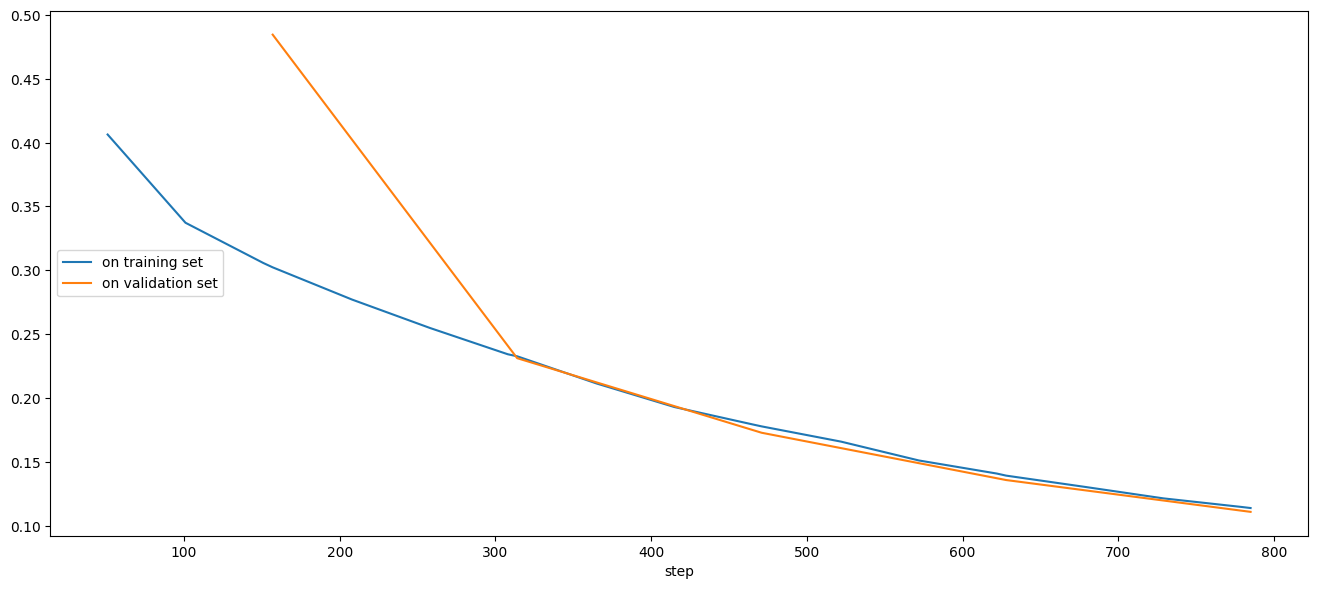

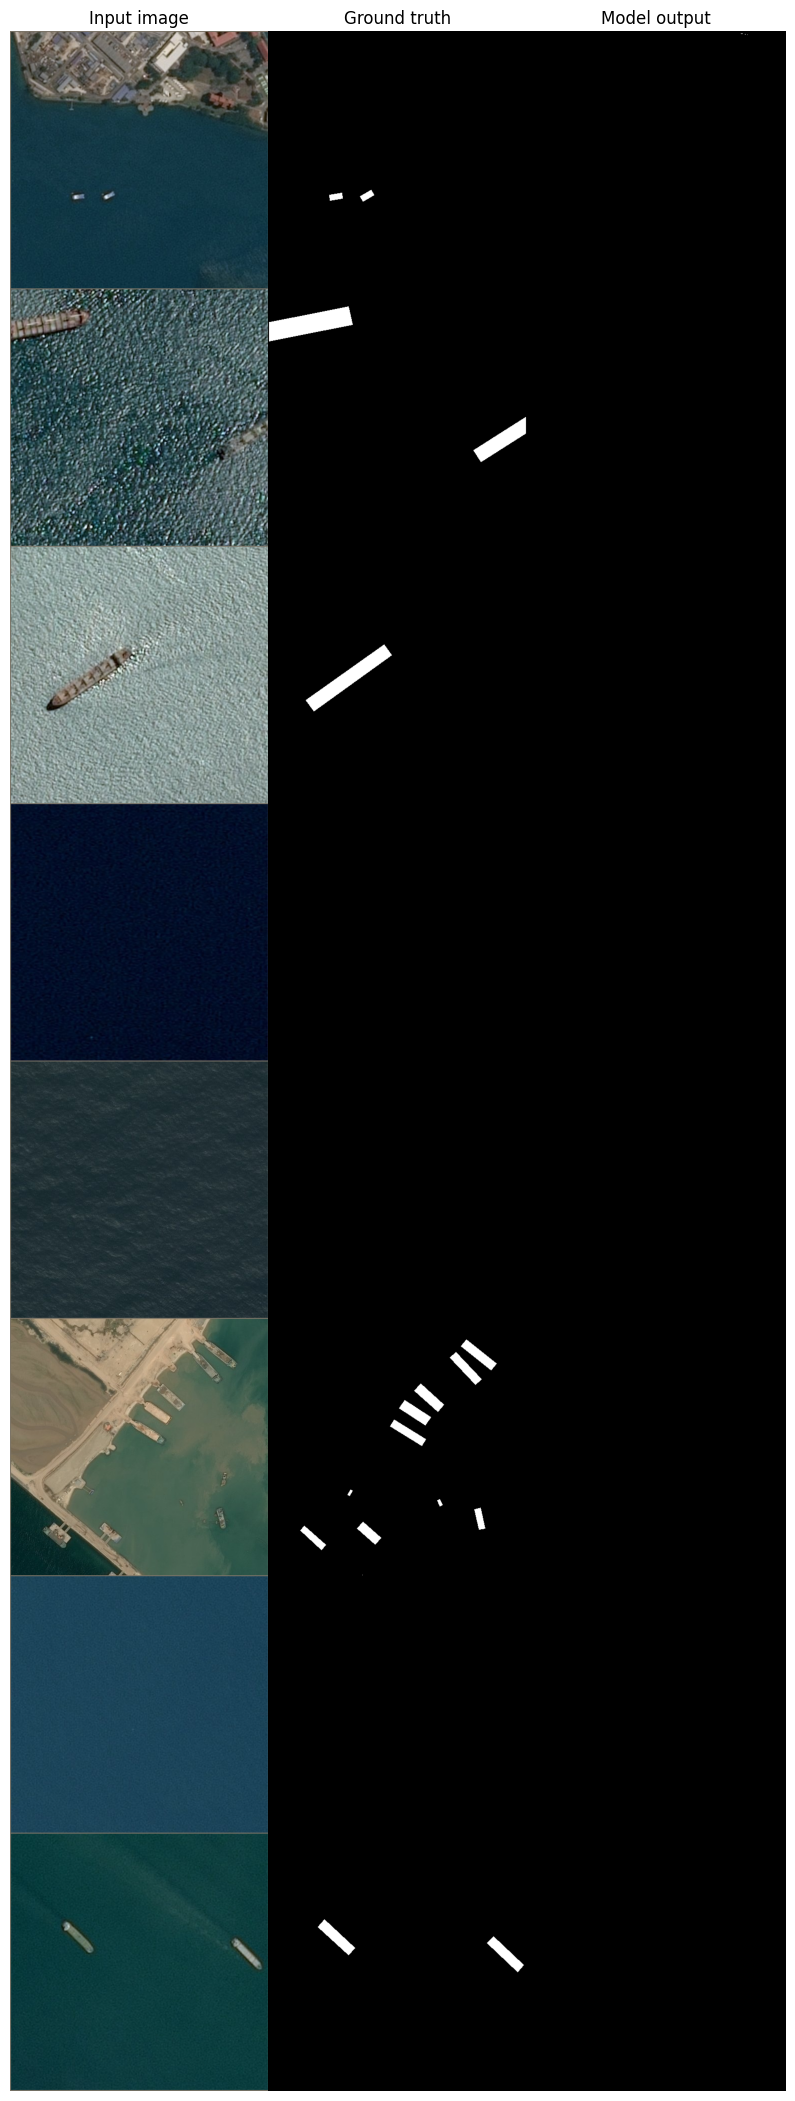

In [11]:
main(model_name='UNET_CUSTOM', run_id=2500)

Using a pre-trained U-Net architecture with a ResNet34 backbone. It shows that the model performs much better than the previous baseline model (with minimal training).

Model: UNET_RESNET34ImgNet, Run ID: 2500
Train samples : 2500 | Validation samples : 250
Model: UNET_RESNET34ImgNet
Using device mps


Epoch 1, lr 0.0001: 100%|█████████▉| 2500/2512 [01:03<00:00, 39.34it/s, loss=0.03002]


Validation
Valid loss: 0.02262, Mean F2: 0.91261, Jaccard: 0.61134, Dice: 0.66456


Epoch 2, lr 0.0001: 100%|█████████▉| 2500/2512 [00:59<00:00, 41.88it/s, loss=0.01766]


Validation
Valid loss: 0.01915, Mean F2: 0.81745, Jaccard: 0.49537, Dice: 0.53245


Epoch 3, lr 0.0001: 100%|█████████▉| 2500/2512 [00:59<00:00, 41.95it/s, loss=0.01514]


Validation
Valid loss: 0.01282, Mean F2: 0.91518, Jaccard: 0.59439, Dice: 0.64338


Epoch 4, lr 0.0001: 100%|█████████▉| 2500/2512 [00:59<00:00, 42.07it/s, loss=0.01275]


Validation
Valid loss: 0.01205, Mean F2: 0.86824, Jaccard: 0.61009, Dice: 0.65902


Epoch 5, lr 0.0001: 100%|█████████▉| 2500/2512 [00:59<00:00, 42.06it/s, loss=0.00991]


Validation
Valid loss: 0.01057, Mean F2: 0.87997, Jaccard: 0.61596, Dice: 0.66864


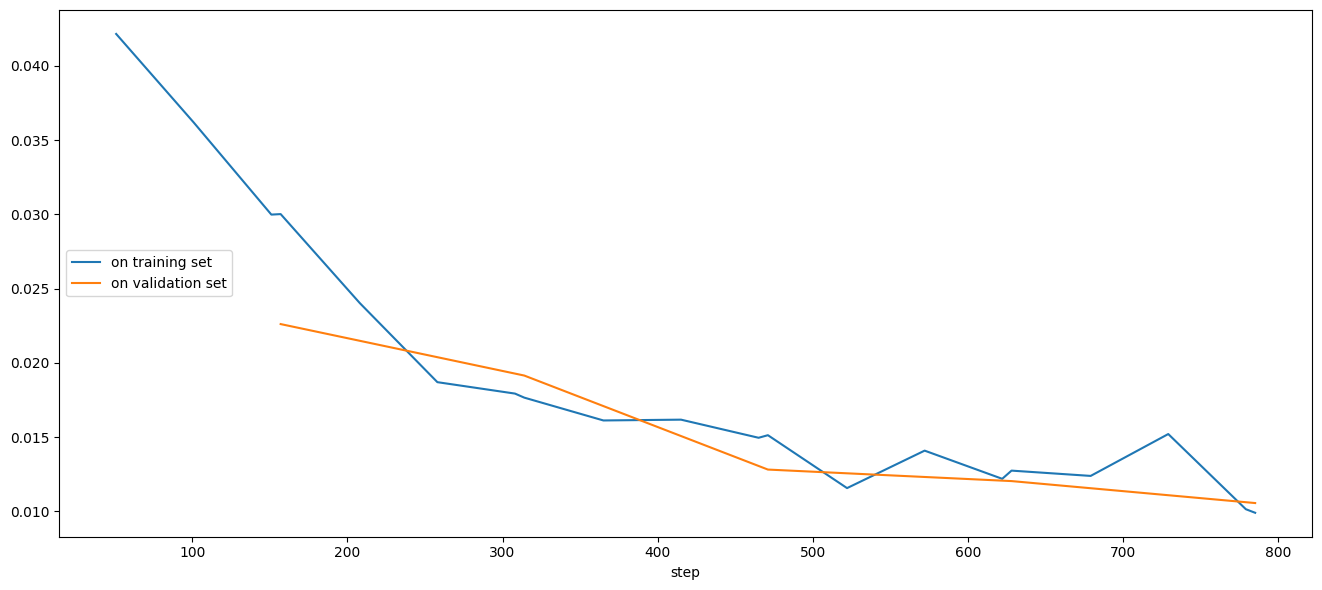

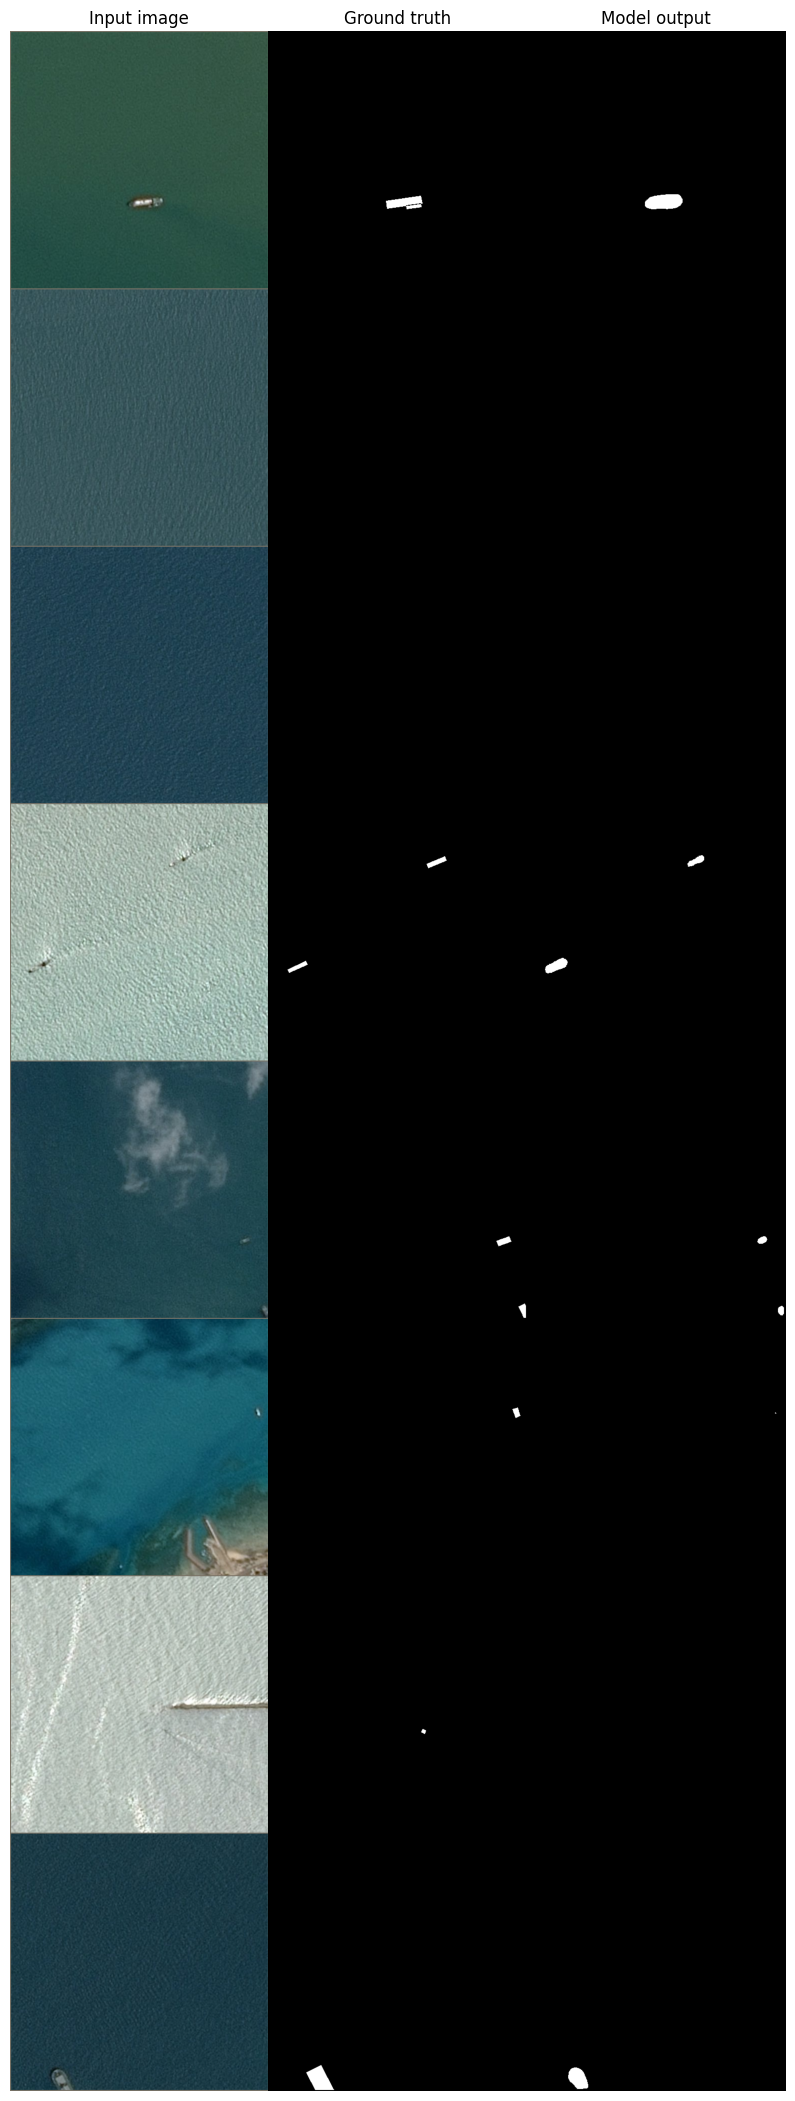

In [17]:
main(model_name='UNET_RESNET34ImgNet', run_id=2500)

Some more images for the same model

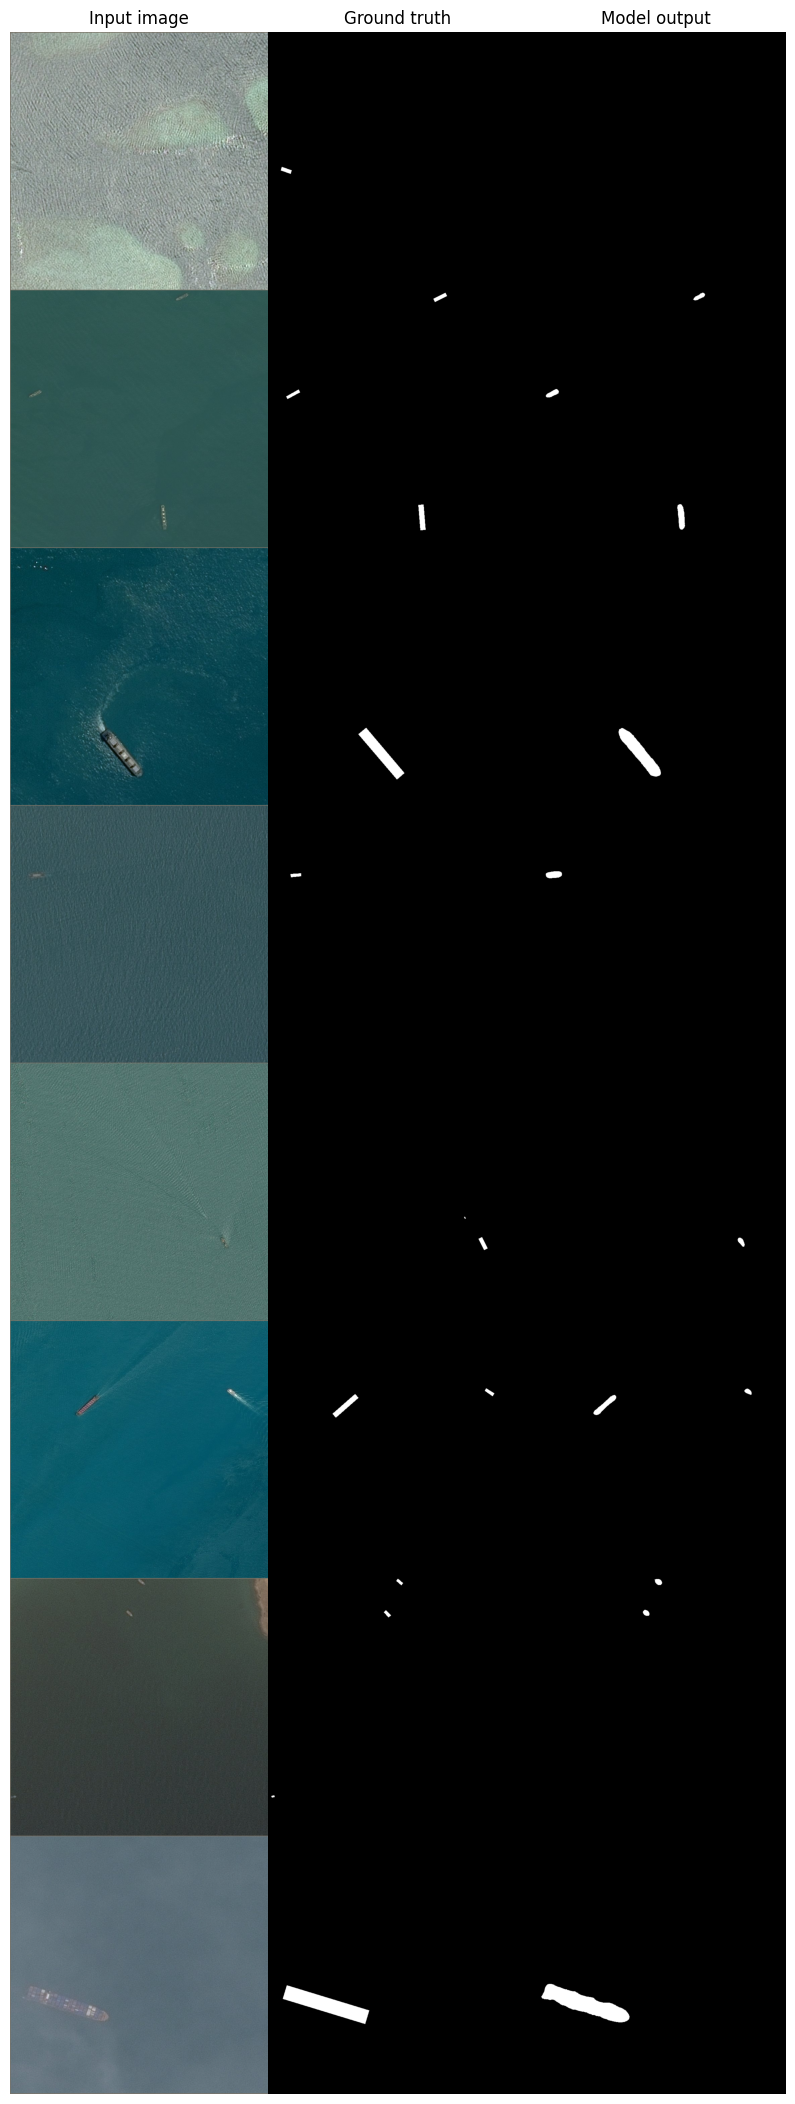

In [18]:
 # Model inference
model = inference.load_model(model_name='UNET_RESNET34ImgNet', run_id=2500)
model.eval()

val_dataset = AirbusDataset(df_val)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=True, num_workers=0)

# Display some images from loader
images, gt = next(iter(val_loader))
gt = gt.data.cpu()
images = images.to(trainer.get_torch_device())
out = model.forward(images)
out = ((out > 0).float()) * 255
images = images.data.cpu()
out = out.data.cpu()
processing.imshow_gt_out(torchvision.utils.make_grid(images, nrow=1),torchvision.utils.make_grid(gt, nrow=1), torchvision.utils.make_grid(out, nrow=1))
plt.show()